In [1]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
# import scikitplot as skplt
import matplotlib.pyplot as plt

In [2]:
sequences = np.load('C:/Users/fareh/Desktop/python project/proposal/Final_seq_9k.npy', allow_pickle=True)
variants = np.load('C:/Users/fareh/Desktop/python project/proposal/Final_variant_names_9k.npy', allow_pickle=True)

In [3]:
attr_new = []
for i in range(len(variants)):
    aa = str(variants[i]).replace("[","")
    aa_1 = aa.replace("]","")
    aa_2 = aa_1.replace("\'","")
    attr_new.append(aa_2)

unique_hst = list(np.unique(attr_new))

int_hosts = []
for ind_unique in range(len(attr_new)):
    variant_tmp = attr_new[ind_unique]
    ind_tmp = unique_hst.index(variant_tmp)
    int_hosts.append(ind_tmp)

print("Attribute data preprocessing Done")

Attribute data preprocessing Done


In [4]:
print(f"Unique variants: {unique_hst}")
print(f"Number of unique variants: {len(unique_hst)}")

Unique variants: [np.str_('B.1.351'), np.str_('B.1.427'), np.str_('B.1.429'), np.str_('B.1.525'), np.str_('B.1.526'), np.str_('B.1.617.2'), np.str_('B.1.621'), np.str_('C.37'), np.str_('P.1')]
Number of unique variants: 9


In [5]:
y = np.array(int_hosts[:])
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(sequences)
X = tokenizer.texts_to_sequences(sequences)
X = pad_sequences(X, padding='post')
print(f'Shape after tokenizing and padding: {X.shape}')

vocab_size = len(tokenizer.word_index) + 1
X_one_hot = np.zeros((len(X), X.shape[1], vocab_size))
for i in range(len(X)):
    for j in range(X.shape[1]):
        if X[i, j] > 0:
            X_one_hot[i, j, X[i, j]] = 1
print(f'Shape after one-hot encoding: {X_one_hot.shape}')

Shape after tokenizing and padding: (9000, 1277)
Shape after one-hot encoding: (9000, 1277, 22)


In [6]:
from sklearn.model_selection import ShuffleSplit

sss = ShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_index, test_index = next(sss.split(X, y))
X_train, X_test = X[train_index], X[test_index]
Y_train, Y_test = y[train_index], y[test_index]

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (8100, 1277)
Y_train shape: (8100,)
X_test shape: (900, 1277)
Y_test shape: (900,)


In [7]:
num_clients = 5

shared_data_ratios = {
    (0, 1): 0.8,
    (0, 2): 0.6,
    (1, 3): 0.4,
    (3, 4): 0.3,
    (2, 4): 0.35
}

train_indices = np.arange(len(X_train))
np.random.shuffle(train_indices)

client_data = {i: [] for i in range(num_clients)}
remaining_data = set(train_indices)

for client_id in range(num_clients):
    client_size = int(len(train_indices) / num_clients)
    client_data[client_id] = set(list(remaining_data)[:client_size])
    remaining_data -= client_data[client_id]

for (client_a, client_b), ratio in shared_data_ratios.items():
    shared_size = int(len(client_data[client_a]) * ratio)
    shared_indices = list(client_data[client_a])[:shared_size]
    client_data[client_b].update(shared_indices)
    client_data[client_a].update(shared_indices)

for client_id in range(num_clients):
    print(f"Client {client_id + 1} has {len(client_data[client_id])} samples.")

client_X = {i: X_train[list(client_data[i])] for i in range(num_clients)}
client_Y = {i: Y_train[list(client_data[i])] for i in range(num_clients)}

for client_id in range(num_clients):
    print(f"Client {client_id + 1}: X -> {client_X[client_id].shape}, Y -> {client_Y[client_id].shape}")

Client 1 has 1620 samples.
Client 2 has 2916 samples.
Client 3 has 2592 samples.
Client 4 has 2786 samples.
Client 5 has 2527 samples.
Client 1: X -> (1620, 1277), Y -> (1620,)
Client 2: X -> (2916, 1277), Y -> (2916,)
Client 3: X -> (2592, 1277), Y -> (2592,)
Client 4: X -> (2786, 1277), Y -> (2786,)
Client 5: X -> (2527, 1277), Y -> (2527,)


In [8]:
for (client_a, client_b), ratio in shared_data_ratios.items():
    shared_indices = client_data[client_a] & client_data[client_b]
    print(f"Overlap between clients {client_a + 1} and {client_b + 1}: {len(shared_indices)} samples")

Overlap between clients 1 and 2: 1296 samples
Overlap between clients 1 and 3: 972 samples
Overlap between clients 2 and 4: 1166 samples
Overlap between clients 4 and 5: 907 samples
Overlap between clients 3 and 5: 907 samples


In [9]:
for i in range(num_clients):
    print(f"Client {i + 1} label distribution:", np.bincount(client_Y[i]))

Client 1 label distribution: [185 181 166 189 178 186 179 191 165]
Client 2 label distribution: [343 318 313 325 339 328 340 320 290]
Client 3 label distribution: [261 258 274 316 298 294 300 296 295]
Client 4 label distribution: [317 306 300 320 290 334 300 323 296]
Client 5 label distribution: [280 255 261 292 285 284 294 276 300]


In [10]:
unique_variants = np.unique(variants)
print(unique_variants)

['B.1.351' 'B.1.427' 'B.1.429' 'B.1.525' 'B.1.526' 'B.1.617.2' 'B.1.621'
 'C.37' 'P.1']


In [71]:
print(f"Number of unique variants: {len(unique_variants)}")

Number of unique variants: 9


In [11]:
attr_new = [str(v).strip("[]'") for v in variants]
unique_hst = list(np.unique(attr_new))
print(f"From previous preprocessing: {unique_hst}")
print(f"From current cell: {unique_variants.tolist()}")
print(f"Are they equal? {set(unique_hst) == set(unique_variants)}")

From previous preprocessing: [np.str_('B.1.351'), np.str_('B.1.427'), np.str_('B.1.429'), np.str_('B.1.525'), np.str_('B.1.526'), np.str_('B.1.617.2'), np.str_('B.1.621'), np.str_('C.37'), np.str_('P.1')]
From current cell: ['B.1.351', 'B.1.427', 'B.1.429', 'B.1.525', 'B.1.526', 'B.1.617.2', 'B.1.621', 'C.37', 'P.1']
Are they equal? True


In [12]:
print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)

X_train.shape: (8100, 1277)
Y_train.shape: (8100,)


In [13]:
import numpy as np
sequences = np.load("C:/Users/fareh/Desktop/python project/proposal/Final_seq_9k.npy")
len_val = [len(seq) for seq in sequences]
unique_lengths = np.unique(len_val)
mean_length = np.mean(len_val)
print(unique_lengths, mean_length)

[   9   12   32   45   74   86   87   99  145  156  161  209  211  213
  224  242  243  246  248  250  253  265  270  276  320  322  386  545
  593  752  826  846  862  956  964 1016 1059 1184 1220 1222 1250 1252
 1253 1256 1260 1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273
 1274 1275 1277] 1263.1631111111112


In [14]:
total_clients = 5
each_part = X_train.shape[0] // total_clients
print(f"Each client's initial training set size: {each_part}")

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)

client_data = {i: set() for i in range(total_clients)}
remaining_data = set(train_indices)

for client_id in range(total_clients):
    client_data[client_id] = set(list(remaining_data)[:each_part])
    remaining_data -= client_data[client_id]

shared_data_ratios = {(0, 1): 0.8, (0, 2): 0.6, (1, 3): 0.4, (3, 4): 0.3, (2, 4): 0.35}
for (client_a, client_b), ratio in shared_data_ratios.items():
    shared_size = int(len(client_data[client_a]) * ratio)
    shared_indices = list(client_data[client_a])[:shared_size]
    client_data[client_b].update(shared_indices)
    client_data[client_a].update(shared_indices)

for client_id in range(total_clients):
    print(f"Client {client_id + 1} has {len(client_data[client_id])} samples.")

Each client's initial training set size: 1620
Client 1 has 1620 samples.
Client 2 has 2916 samples.
Client 3 has 2592 samples.
Client 4 has 2786 samples.
Client 5 has 2527 samples.


In [15]:
for (client_a, client_b), ratio in shared_data_ratios.items():
    shared_indices = client_data[client_a] & client_data[client_b]
    expected_shared = int(len(client_data[client_a]) * ratio)
    print(f"Overlap between clients {client_a + 1} and {client_b + 1}: {len(shared_indices)} samples (expected ~{expected_shared})")

Overlap between clients 1 and 2: 1296 samples (expected ~1296)
Overlap between clients 1 and 3: 972 samples (expected ~972)
Overlap between clients 2 and 4: 1166 samples (expected ~1166)
Overlap between clients 4 and 5: 907 samples (expected ~835)
Overlap between clients 3 and 5: 907 samples (expected ~907)


In [16]:
import numpy as np

total_clients = 5
each_part = X_train.shape[0] // total_clients

train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)

client_data = {i: set() for i in range(total_clients)}
remaining_data = set(train_indices)

for client_id in range(total_clients):
    client_data[client_id] = set(list(remaining_data)[:each_part])
    remaining_data -= client_data[client_id]

shared_data_ratios = {(0, 1): 0.8, (0, 2): 0.6, (1, 3): 0.4, (3, 4): 0.3, (2, 4): 0.35}
for (client_a, client_b), ratio in shared_data_ratios.items():
    shared_size = int(len(client_data[client_a]) * ratio)
    shared_indices = list(client_data[client_a])[:shared_size]
    client_data[client_b].update(shared_indices)

training_list = [X_train[list(client_data[i])] for i in range(total_clients)]
target_list = [Y_train[list(client_data[i])] for i in range(total_clients)]

for i in range(total_clients):
    print(f"Client {i + 1}: X -> {training_list[i].shape}, Y -> {target_list[i].shape}")
    print(f"Client {i + 1} label distribution:", np.bincount(target_list[i]))

for (client_a, client_b), ratio in shared_data_ratios.items():
    shared_indices = client_data[client_a] & client_data[client_b]
    expected_shared = int(len(client_data[client_a]) * ratio)
    print(f"Overlap between clients {client_a + 1} and {client_b + 1}: {len(shared_indices)} samples (expected ~{expected_shared})")

Client 1: X -> (1620, 1277), Y -> (1620,)
Client 1 label distribution: [185 181 166 189 178 186 179 191 165]
Client 2: X -> (2916, 1277), Y -> (2916,)
Client 2 label distribution: [343 318 313 325 339 328 340 320 290]
Client 3: X -> (2592, 1277), Y -> (2592,)
Client 3 label distribution: [261 258 274 316 298 294 300 296 295]
Client 4: X -> (2786, 1277), Y -> (2786,)
Client 4 label distribution: [317 306 300 320 290 334 300 323 296]
Client 5: X -> (2527, 1277), Y -> (2527,)
Client 5 label distribution: [280 255 261 292 285 284 294 276 300]
Overlap between clients 1 and 2: 1296 samples (expected ~1296)
Overlap between clients 1 and 3: 972 samples (expected ~972)
Overlap between clients 2 and 4: 1166 samples (expected ~1166)
Overlap between clients 4 and 5: 907 samples (expected ~835)
Overlap between clients 3 and 5: 907 samples (expected ~907)


Training model for Client 1...
Client 1 model trained
Client 1 accuracy: 91.67%
Training model for Client 2...
Client 2 model trained
Client 2 accuracy: 92.22%
Training model for Client 3...
Client 3 model trained
Client 3 accuracy: 90.67%
Training model for Client 4...
Client 4 model trained
Client 4 accuracy: 91.22%
Training model for Client 5...
Client 5 model trained
Client 5 accuracy: 90.78%


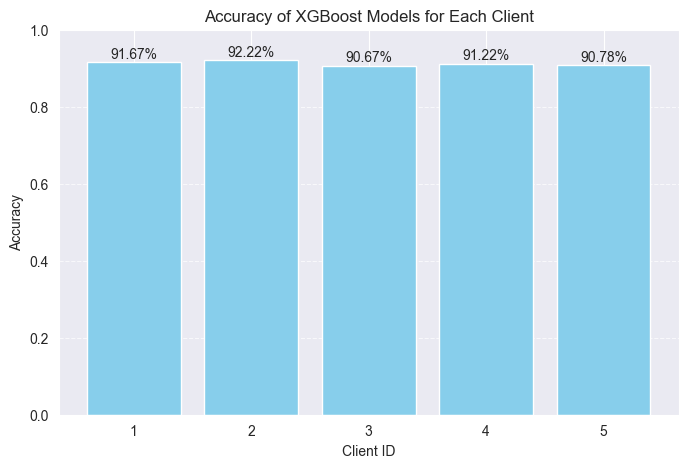

In [17]:
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

total_clients = 5

client_models = []
accuracies = []

for i in range(total_clients):
    print(f"Training model for Client {i + 1}...")
    model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
    X_c_flat = training_list[i].reshape(training_list[i].shape[0], -1)
    model.fit(X_c_flat, target_list[i])
    client_models.append(model)
    print(f"Client {i + 1} model trained")

    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    y_pred = model.predict(X_test_flat)
    acc = accuracy_score(Y_test, y_pred)
    accuracies.append(acc)
    print(f"Client {i + 1} accuracy: {acc * 100:.2f}%")

plt.figure(figsize=(8, 5))
plt.bar(range(1, total_clients + 1), accuracies, color='skyblue')
plt.xlabel('Client ID')
plt.ylabel('Accuracy')
plt.title('Accuracy of XGBoost Models for Each Client')
plt.xticks(range(1, total_clients + 1))
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i + 1, acc + 0.01, f'{acc * 100:.2f}%', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Train label distribution: [7 4 5 6 6 5 8 4 5]
Test label distribution: [2 0 2 2 1 1 1 1 0]
Graph 1/50, Loss: 2.2048
Graph 2/50, Loss: 2.1565
Graph 3/50, Loss: 2.2113
Graph 4/50, Loss: 1.7727
Graph 5/50, Loss: 2.2251
Graph 6/50, Loss: 2.2638
Graph 7/50, Loss: 2.2093
Graph 8/50, Loss: 2.2881
Graph 9/50, Loss: 2.3017
Graph 10/50, Loss: 1.9577
Graph 11/50, Loss: 1.3848
Graph 12/50, Loss: 2.1826
Graph 13/50, Loss: 2.2986
Graph 14/50, Loss: 1.3849
Graph 15/50, Loss: 2.3029
Graph 16/50, Loss: 2.3078
Graph 17/50, Loss: 2.2824
Graph 18/50, Loss: 2.2427
Graph 19/50, Loss: 2.0845
Graph 20/50, Loss: 2.2425
Graph 21/50, Loss: 1.9587
Graph 22/50, Loss: 1.4168
Graph 23/50, Loss: 2.1966
Graph 24/50, Loss: 2.1001
Graph 25/50, Loss: 2.2026
Graph 26/50, Loss: 2.1036
Graph 27/50, Loss: 1.4024
Graph 28/50, Loss: 1.4982
Graph 29/50, Loss: 1.3801
Graph 30/50, Loss: 1.3790
Graph 31/50, Loss: 1.9811
Graph 32/50, Loss: 1.3720
Graph 33/50, Loss: 1.6486
Graph 34/50, Loss: 2.2765
Graph 35/50, Loss: 1.3761
Graph 36

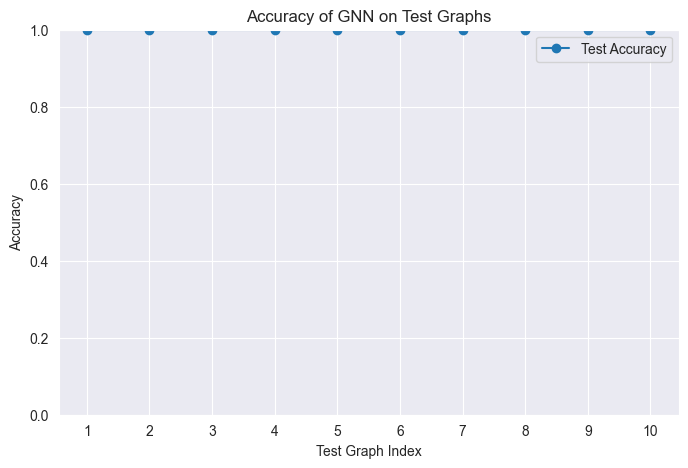

In [18]:
import numpy as np
import torch
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GraphConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GraphConv(9, 512)
        self.conv2 = GraphConv(512, 256)
        self.conv3 = GraphConv(256, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, 9)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

num_nodes = 5
num_graphs = 50
num_test_graphs = 10
embedding_dim = 9

edge_index_list = []
for i in range(num_nodes):
    for j in range(i+1, num_nodes):
        edge_index_list.append([i, j])
        edge_index_list.append([j, i])
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t()
edge_weight = torch.ones(edge_index.size(1), dtype=torch.float)

np.random.seed(42)
graphs = []
for g in range(num_graphs):
    embeddings = []
    label = np.random.randint(0, embedding_dim)
    for n in range(num_nodes):
        emb = np.random.normal(0, 0.01, embedding_dim)
        emb[label] = 1.0 + np.random.normal(0, 0.05)
        emb = np.clip(emb, 0, 1)
        emb /= emb.sum()
        embeddings.append(emb)
    embeddings = np.array(embeddings)
    x = torch.tensor(embeddings, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    graphs.append(data)

test_graphs = []
for g in range(num_test_graphs):
    embeddings = []
    label = np.random.randint(0, embedding_dim)
    for n in range(num_nodes):
        emb = np.random.normal(0, 0.01, embedding_dim)
        emb[label] = 1.0 + np.random.normal(0, 0.05)
        emb = np.clip(emb, 0, 1)
        emb /= emb.sum()
        embeddings.append(emb)
    embeddings = np.array(embeddings)
    x = torch.tensor(embeddings, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)
    test_graphs.append(data)

train_labels = [graph.y.item() for graph in graphs]
test_labels = [graph.y.item() for graph in test_graphs]
print("Train label distribution:", np.bincount(train_labels, minlength=embedding_dim))
print("Test label distribution:", np.bincount(test_labels, minlength=embedding_dim))

model = GraphConvModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-6)
model.train()
for g in range(num_graphs):
    data = graphs[g]
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out, data.y.expand(num_nodes))
    loss.backward()
    optimizer.step()
    print(f"Graph {g + 1}/{num_graphs}, Loss: {loss.item():.4f}")

model.eval()
test_accuracies = []
for g in range(num_test_graphs):
    data = test_graphs[g]
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        acc = (pred == data.y).float().mean().item()
        test_accuracies.append(acc)
        print(f"Test Graph {g + 1}/{num_test_graphs}, Accuracy: {acc * 100:.2f}%")

mean_accuracy = np.mean(test_accuracies) * 100
print(f"Average Test Accuracy: {mean_accuracy:.2f}%")

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_test_graphs + 1), test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('Test Graph Index')
plt.ylabel('Accuracy')
plt.title('Accuracy of GNN on Test Graphs')
plt.xticks(range(1, num_test_graphs + 1))
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.show()

torch.save(model.state_dict(), 'trained_gnn_model.pth')

In [19]:
import numpy as np

embedding_dim = 9
num_nodes = 5
np.random.seed(42)

label = np.random.randint(0, embedding_dim)
print(f"Selected label (variant index): {label}")

embeddings = []
for n in range(num_nodes):
    emb = np.random.normal(0, 0.01, embedding_dim)
    emb[label] = 1.0 + np.random.normal(0, 0.05)
    emb = np.clip(emb, 0, 1)
    emb /= emb.sum()
    embeddings.append(emb)

print("\nSample embeddings for 5 nodes (9-dimensional, normalized):")
for i, emb in enumerate(embeddings):
    print(f"Node {i + 1}: {emb.round(4)}")
print(f"Sum of each embedding: {[emb.sum().round(4) for emb in embeddings]}")

Selected label (variant index): 6

Sample embeddings for 5 nodes (9-dimensional, normalized):
Node 1: [0.     0.0053 0.0048 0.0139 0.     0.     0.972  0.     0.004 ]
Node 2: [8.000e-04 0.000e+00 2.000e-04 0.000e+00 0.000e+00 0.000e+00 9.976e-01
 0.000e+00 1.400e-03]
Node 3: [0.0108 0.     0.     0.0182 0.     0.0106 0.9497 0.     0.0107]
Node 4: [0.000e+00 0.000e+00 5.600e-03 0.000e+00 0.000e+00 0.000e+00 9.937e-01
 7.000e-04 0.000e+00]
Node 5: [0.0065 0.     0.     0.0111 0.0073 0.0247 0.9308 0.0153 0.0043]
Sum of each embedding: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


In [ ]:
 import numpy as np
import torch
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
import torch.nn.functional as F
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt

total_clients = 5
num_nodes = total_clients

client_models = []
for i in range(total_clients):
    print(f"Training initial model for Client {i + 1}...")
    model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
    X_c_flat = training_list[i].reshape(training_list[i].shape[0], -1)
    model.fit(X_c_flat, target_list[i])
    client_models.append(model)
    print(f"Client {i + 1} model trained")

np.random.seed(42)
sample_indices = np.random.choice(X_test.shape[0], size=350, replace=False)
X_valid = X_test[sample_indices]
Y_valid = Y_test[sample_indices]
print(f"Validation set: {X_valid.shape[0]} samples")

class GraphConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GraphConv(9, 512)
        self.conv2 = GraphConv(512, 256)
        self.conv3 = GraphConv(256, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, 9)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

shared_data_ratios = {(0, 1): 0.8, (0, 2): 0.6, (1, 3): 0.4, (3, 4): 0.3, (2, 4): 0.35}
edge_index_list = []
edge_weight_list = []
for (client_a, client_b), ratio in shared_data_ratios.items():
    edge_index_list.append([client_a, client_b])
    edge_index_list.append([client_b, client_a])
    edge_weight_list.extend([ratio, ratio])
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t()
edge_weight = torch.tensor(edge_weight_list, dtype=torch.float)

model = GraphConvModel()
model.load_state_dict(torch.load('trained_gnn_model.pth'))
model.eval()  #

client_accuracies = [[] for _ in range(total_clients)]
server_accuracies = []

for idx, (sample, true_label) in enumerate(zip(X_valid, Y_valid)):
    print(f"Processing validation sample {idx + 1}/350...")

    sample_flat = sample.reshape(1, -1)
    client_probs = [client_models[i].predict_proba(sample_flat)[0] for i in range(total_clients)]
    client_probs = np.array(client_probs)

    x = torch.tensor(client_probs, dtype=torch.float)
    y = torch.tensor([true_label], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

    with torch.no_grad():
        server_pred = model(data)
        server_prob = server_pred.mean(dim=0).numpy()
        server_acc = (server_pred.argmax(dim=1) == data.y).float().mean().item()
        server_accuracies.append(server_acc)

    for i in range(total_clients):
        client_prob = client_probs[i]
        mse = mean_squared_error(client_prob, server_prob)
        if mse > 0.01:
            X_c_flat = training_list[i].reshape(training_list[i].shape[0], -1)
            client_models[i].fit(X_c_flat, target_list[i], xgb_model=client_models[i].get_booster())
            print(f"Client {i + 1} updated due to MSE: {mse:.4f}")

        y_pred = client_models[i].predict(sample_flat)
        acc = (y_pred[0] == true_label).astype(float)
        client_accuracies[i].append(acc)

client_avg_accuracies = [np.mean(acc) * 100 for acc in client_accuracies]
server_avg_accuracy = np.mean(server_accuracies) * 100

print("Validation label distribution:", np.bincount(Y_valid))

print("\nAverage accuracies:")
for i in range(total_clients):
    print(f"Client {i + 1}: {client_avg_accuracies[i]:.2f}%")
print(f"Server (GNN): {server_avg_accuracy:.2f}%")

plt.figure(figsize=(10, 6))
for i in range(total_clients):
    plt.plot(client_accuracies[i], label=f'Client {i + 1}')
plt.plot(server_accuracies, label='Server (GNN)', linestyle='--', linewidth=2)
plt.xlabel('Validation Sample Index')
plt.ylabel('Accuracy')
plt.title('Accuracy per Sample for Clients and Server (350 Validation Samples)')
plt.legend()
plt.grid(True)
plt.show()

Training initial model for Client 1...
Client 1 model trained
Training initial model for Client 2...
Client 2 model trained
Training initial model for Client 3...
Client 3 model trained
Training initial model for Client 4...
Client 4 model trained
Training initial model for Client 5...
Client 5 model trained
Validation set: 350 samples
Processing validation sample 1/350...
Client 1 updated due to MSE: 0.0904
Client 2 updated due to MSE: 0.0905
Client 3 updated due to MSE: 0.0905
Client 4 updated due to MSE: 0.0905
Client 5 updated due to MSE: 0.0905
Processing validation sample 2/350...
Client 1 updated due to MSE: 0.0905
Client 2 updated due to MSE: 0.0905
Client 3 updated due to MSE: 0.0905
Client 4 updated due to MSE: 0.0905
Client 5 updated due to MSE: 0.0905
Processing validation sample 3/350...
Client 1 updated due to MSE: 0.0418
Client 2 updated due to MSE: 0.0609
Client 3 updated due to MSE: 0.0534
Client 4 updated due to MSE: 0.0418
Client 5 updated due to MSE: 0.0834
Processi

In [ ]:
import numpy as np
import torch
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data
import torch.nn.functional as F
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt

total_clients = 5
num_nodes = total_clients

client_models = []
for i in range(total_clients):
    print(f"Training initial model for Client {i + 1}...")
    model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
    X_c_flat = training_list[i].reshape(training_list[i].shape[0], -1)
    model.fit(X_c_flat, target_list[i])
    client_models.append(model)
    print(f"Client {i + 1} model trained")

np.random.seed(42)
valid_indices = np.random.choice(X_test.shape[0], size=350, replace=False)
test_indices = np.setdiff1d(np.arange(X_test.shape[0]), valid_indices)
X_test_remain = X_test[test_indices]
Y_test_remain = Y_test[test_indices]
print(f"Test set: {X_test_remain.shape[0]} samples")

class GraphConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GraphConv(9, 512)
        self.conv2 = GraphConv(512, 256)
        self.conv3 = GraphConv(256, 128)
        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, 9)
        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index, edge_weight))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index, edge_weight))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

shared_data_ratios = {(0, 1): 0.8, (0, 2): 0.6, (1, 3): 0.4, (3, 4): 0.3, (2, 4): 0.35}
edge_index_list = []
edge_weight_list = []
for (client_a, client_b), ratio in shared_data_ratios.items():
    edge_index_list.append([client_a, client_b])
    edge_index_list.append([client_b, client_a])
    edge_weight_list.extend([ratio, ratio])
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t()
edge_weight = torch.tensor(edge_weight_list, dtype=torch.float)

model = GraphConvModel()
model.load_state_dict(torch.load('trained_gnn_model.pth'))
model.eval()

client_accuracies = [[] for _ in range(total_clients)]
server_accuracies = []
client_updates = [0] * total_clients

for idx, (sample, true_label) in enumerate(zip(X_test_remain, Y_test_remain)):
    print(f"Processing test sample {idx + 1}/550...")

    sample_flat = sample.reshape(1, -1)
    client_probs = [client_models[i].predict_proba(sample_flat)[0] for i in range(total_clients)]
    client_probs = np.array(client_probs)

    x = torch.tensor(client_probs, dtype=torch.float)
    y = torch.tensor([true_label], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)

    with torch.no_grad():
        server_pred = model(data)
        server_prob = server_pred.mean(dim=0).numpy()
        server_acc = (server_pred.argmax(dim=1) == data.y).float().mean().item()
        server_accuracies.append(server_acc)

    for i in range(total_clients):
        client_prob = client_probs[i]
        mse = mean_squared_error(client_prob, server_prob)
        if mse > 0.01:
            X_c_flat = training_list[i].reshape(training_list[i].shape[0], -1)
            client_models[i].fit(X_c_flat, target_list[i], xgb_model=client_models[i].get_booster())
            client_updates[i] += 1
            print(f"Client {i + 1} updated due to MSE: {mse:.4f}")

        y_pred = client_models[i].predict(sample_flat)
        acc = (y_pred[0] == true_label).astype(float)
        client_accuracies[i].append(acc)

client_avg_accuracies = [np.mean(acc) * 100 for acc in client_accuracies]
server_avg_accuracy = np.mean(server_accuracies) * 100

print("Test label distribution:", np.bincount(Y_test_remain))

print("\nAverage accuracies:")
for i in range(total_clients):
    print(f"Client {i + 1}: {client_avg_accuracies[i]:.2f}% (Updated {client_updates[i]} times)")
print(f"Server (GNN): {server_avg_accuracy:.2f}%")

plt.figure(figsize=(10, 6))
for i in range(total_clients):
    plt.plot(client_accuracies[i], label=f'Client {i + 1}')
plt.plot(server_accuracies, label='Server (GNN)', linestyle='-- ', linewidth=2)
plt.xlabel('Test Sample Index')
plt.ylabel('Accuracy')
plt.title('Accuracy per Sample for Clients and Server (550 Test Samples)')
plt.legend()
plt.grid(True)
plt.show()

Training initial model for Client 1...
Client 1 model trained
Training initial model for Client 2...
Client 2 model trained
Training initial model for Client 3...
Client 3 model trained
Training initial model for Client 4...
Client 4 model trained
Training initial model for Client 5...
Client 5 model trained
Test set: 550 samples
Processing test sample 1/550...
Client 1 updated due to MSE: 0.0888
Client 2 updated due to MSE: 0.0889
Client 3 updated due to MSE: 0.0889
Client 4 updated due to MSE: 0.0889
